## In questo file andiamo ad applicare la PCA per il dataset totale

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from matplotlib.lines import Line2D
import os
from sklearn_som.som import SOM

In [2]:
with open('pickle/scaled_total_document.pickle', 'rb') as handle:
    df = pickle.load(handle)

In [3]:
#contiamo il numero di feature per label

df_prova = df.groupby(['Label'])['Label'].count()

df_prova=df_prova.to_frame()
print(df_prova)
df_prova.set_index('Label')
df_prova=df_prova.rename(columns={'Label':'Count'})

         Label
Label         
0      7313104
1       576191


In [4]:
#creiamo un array in cui andiamo a mettere le 5 feature più importanti per filtrare poi il dataframe

import csv

results = []
with open('top_feature/top5_totale.csv', newline='') as inputfile:
    for row in csv.reader(inputfile):
        results.append(row[0])

results.pop(0)
print(results)

['Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Seg Size Min', 'Flow Pkts/s', 'Fwd Pkt Len Std']


In [5]:
#otteniamo il dataframe con solo le 5 feature più importanti

df_filtrato = pd.DataFrame()
for a in df.head(0):
    if a in results:
        df_filtrato[a] = df[a]

df_filtrato['Label'] = df['Label']
display(df_filtrato)

,Fwd Pkt Len Std,Flow Pkts/s,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
4089954,0.213969,4.122862e-06,0.222794,0.003571,0.666667,0
4089955,0.000000,1.661031e-09,0.000000,0.000000,0.000000,0
4089956,0.000000,1.661035e-09,0.000000,0.000000,0.000000,0
4089957,0.000000,1.661037e-09,0.000000,0.000000,0.000000,0
4089958,0.000000,1.661035e-09,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...
12038697,0.000000,5.313996e-06,0.015640,0.000015,0.416667,0
12038698,0.000000,3.976831e-06,1.000000,0.003235,0.416667,0
12038699,0.000000,1.587301e-02,0.147034,0.000015,0.416667,0
12038700,0.000000,2.745170e-06,0.015640,0.000015,0.416667,0


In [6]:
malign = df_filtrato[df_filtrato.Label == 1]
benign = df_filtrato[df_filtrato.Label == 0]

print("Benign: ", len(benign), "Bot: ", len(malign))

Benign:  7313104 Bot:  576191


In [7]:
#bilanciamento del dataset
balanced_d = pd.concat([malign, benign.sample(len(malign))])
bal_x = balanced_d.iloc[:,:-1]
bal_y = balanced_d.iloc[:,-1:]
balanced_d.shape

(1152382, 6)

### Applicazione della PCA

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver="auto").fit(bal_x)
pca_x = pca.transform(bal_x)

In [9]:
n_clusters = len(balanced_d['Label'].unique())  # numero di cluster

In [10]:
#applicazione del kmeans
km = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_pred = km.fit_predict(pca_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[y_pred == i]
    cluster_classes = bal_y[y_pred == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [11]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe
for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):
        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [12]:
# se il numero del cluster e la classe non coincidono, andiamo ad effettuare uno switch

indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(y_pred))
    if y_pred[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        y_pred[a] = true_value

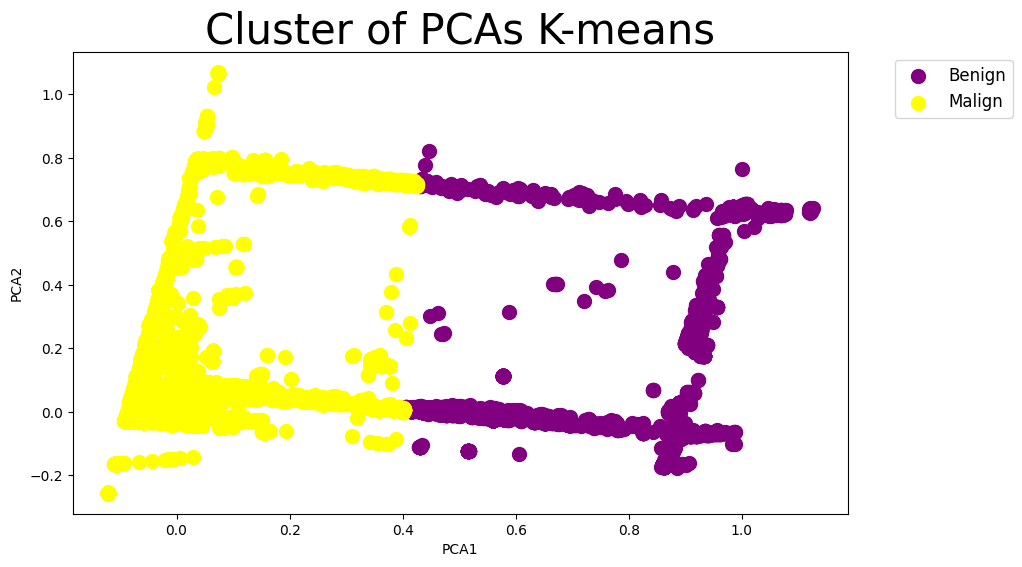

In [13]:
#Plot dei risultati

plt.figure(figsize=(10,6))
plt.title('Cluster of PCAs K-means', fontsize = 30)

plt.scatter(pca_x[y_pred == 0, 0], pca_x[y_pred == 0, 1], s = 100, c = 'purple', label = "Benign")
plt.scatter(pca_x[y_pred == 1, 0], pca_x[y_pred == 1, 1], s = 100, c = 'yellow', label = "Malign")

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1), loc='upper left')

title = "KMeans_PCA"
if not os.path.exists('image/clustering_totale/'):
    os.makedirs('image/clustering_totale/')
plt.savefig('image/clustering_totale/'+ title +'.png',bbox_inches='tight')

plt.show()

In [14]:
accuracy_kmeans = str(accuracy_score(y_pred,bal_y))
precision_kmeans = str(precision_score(y_pred,bal_y,average='macro'))
recall_kmeans = str(recall_score(y_pred,bal_y,average='macro'))

# accuratezza kmeans
print("accuratezza" + accuracy_kmeans)
# precision kmeans
print("precision" + precision_kmeans)
# recall kemans
print("recall" + recall_kmeans)


metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_kmeans,precision_kmeans,recall_kmeans]
})

if not os.path.exists('metriche/'):
    os.makedirs('metriche/')

metriche.to_csv('metriche/metriche_kmeans_pca_totale.csv',index=False)

accuratezza0.5807666207906753
precision0.5807666207906753
recall0.7719657550023222


In [15]:
# Eseguiamo il clustering

n_clusters = len(balanced_d['Label'].unique())  # numero di cluster

y_som = SOM(m=1, n=2, dim=2)

y_som.fit(pca_x)

predictions = y_som.predict(pca_x)

# Associazione del cluster i-esimo con la classe i-esima
cluster_class_mapping = {}
for i in range(n_clusters):
    cluster_samples = pca_x[predictions == i]
    cluster_classes = bal_y[predictions == i]
    unique_classes, class_counts = np.unique(cluster_classes, return_counts=True)
    dominant_class = unique_classes[np.argmax(class_counts)]
    cluster_class_mapping[i] = dominant_class

In [16]:
difference = pd.DataFrame(data=[],columns=['num_cluster','num_class'])

# Stampiamo l'associazione del cluster con la classe

for i in range(n_clusters):
    if(i != cluster_class_mapping[i]):

        new_row = pd.Series({'num_cluster': i, 'num_class': cluster_class_mapping[i]})
        difference = pd.concat([difference,new_row.to_frame().T],ignore_index=True)

In [17]:
indici = []

for a in difference['num_cluster']:
    indici.append([
    index for index in range(len(predictions))
    if predictions[index] == a
])

for ind,true_value in zip(indici,difference['num_class']):
    for a in ind:
        predictions[a] = true_value

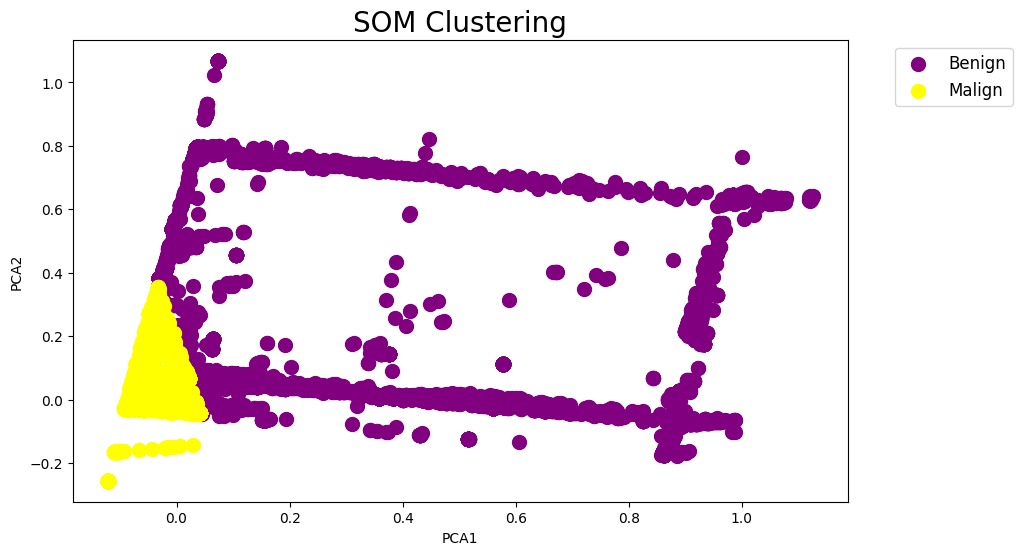

In [18]:
# Plot dei risultati
plt.figure(figsize=(10,6))

plt.scatter(pca_x[predictions == 0, 0], pca_x[predictions == 0, 1], s = 100, c = 'purple', label = "Benign")
plt.scatter(pca_x[predictions == 1, 0], pca_x[predictions == 1, 1], s = 100, c = 'yellow', label = "Malign")

plt.title('SOM Clustering', fontsize = 20)
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# Add legend
plt.legend(fontsize='large',bbox_to_anchor=(1.05, 1), loc='upper left')

title = ("SOM_PCA")
if not os.path.exists('image/clustering_totale/'):
    os.makedirs('image/clustering_totale/')
plt.savefig('image/clustering_totale/'+ title +'.png',bbox_inches='tight')


plt.show()

In [19]:
accuracy_som = str(accuracy_score(predictions,bal_y))
precision_som = str(precision_score(predictions,bal_y,average='macro'))
recall_som = str(recall_score(predictions,bal_y,average='macro'))

# accuratezza gerarchico
print("accuratezza " + accuracy_som)
# precision gerarchico
print("precision " + precision_som)
# recall gerarchico
print("recall " + recall_som)

metriche = pd.DataFrame({
    'metriche': ["accuracy","precision","recall"],
    'valori': [accuracy_som,precision_som,recall_som]
})

if not os.path.exists('metriche/'):
    os.makedirs('metriche/')

metriche.to_csv('metriche/metriche_som_pca_totale.csv',index=False)

accuratezza 0.6099956438056131
precision 0.6099956438056131
recall 0.7808975015234614
